In [138]:
from utilities import *

#silent warnings
import warnings
warnings.filterwarnings('ignore')

raw_data = pd.read_excel("data/Datos_Market_copy.xlsx")

sa = SalesAnalysis(raw_data)

data = sa.data[sa.brand35]

### Firstly, we analyse the seasonality

To be able to do it, we need to filter data with a specific supermarket, variant, and pack size.

In [139]:
filter_data = data[
    (data["supermarket"] == "supermarket-A")
    & (data["variant"] == "standard")
    & (data["pack.size"] == "351 - 500 GR")
]
# filter_data = data[
#     (data["supermarket"] == "supermarket-C")
#     & (data["variant"] == "standard")
#     & (data["pack.size"] == "701 - 1000 GR")
# ]
# filter_data = data[
#     (data["supermarket"] == "supermarket-A")
#     & (data["variant"] == "flavoured")
#     & (data["pack.size"] == "0 - 350 GR")
# ]

Check visualizations for seasonal patterns.

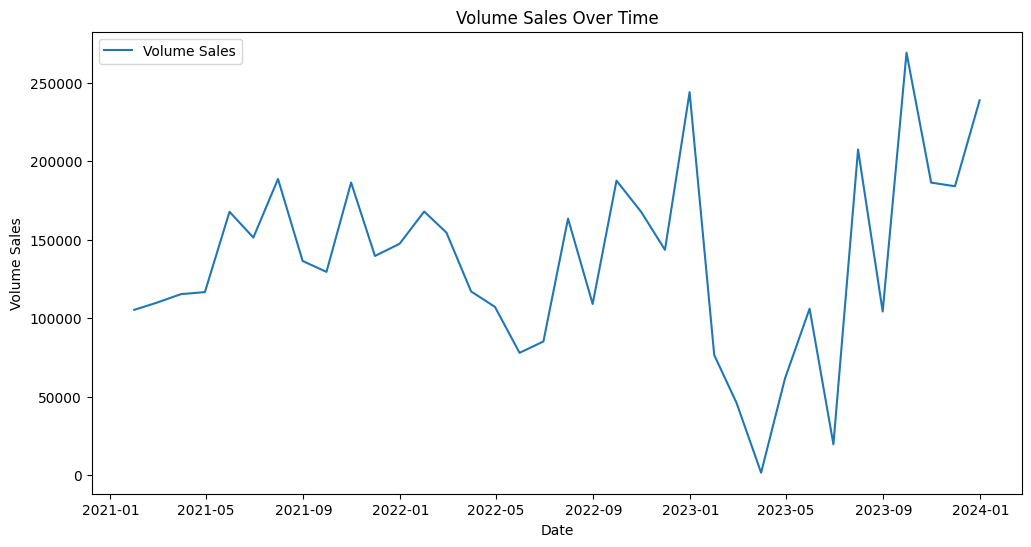

In [140]:
# plotting the time series to see if there is seasonality
plt.figure(figsize=(12, 6))
plt.plot(filter_data["date"], filter_data["volume.sales"], label="Volume Sales")
plt.xlabel("Date")
plt.ylabel("Volume Sales")
plt.title("Volume Sales Over Time")
plt.legend()
plt.show()

In theory, it seems we don't have seasonality
However, we are going to crop data in 3 parts to see if we can find any seasonal patterns

Data from 2021-01-31 to 2023-12-31
Crop 1 from 2021-01-31 to 2021-12-31
Crop 2 from 2022-01-31 to 2022-12-31
Crop 3 from 2023-01-31 to 2023-12-31


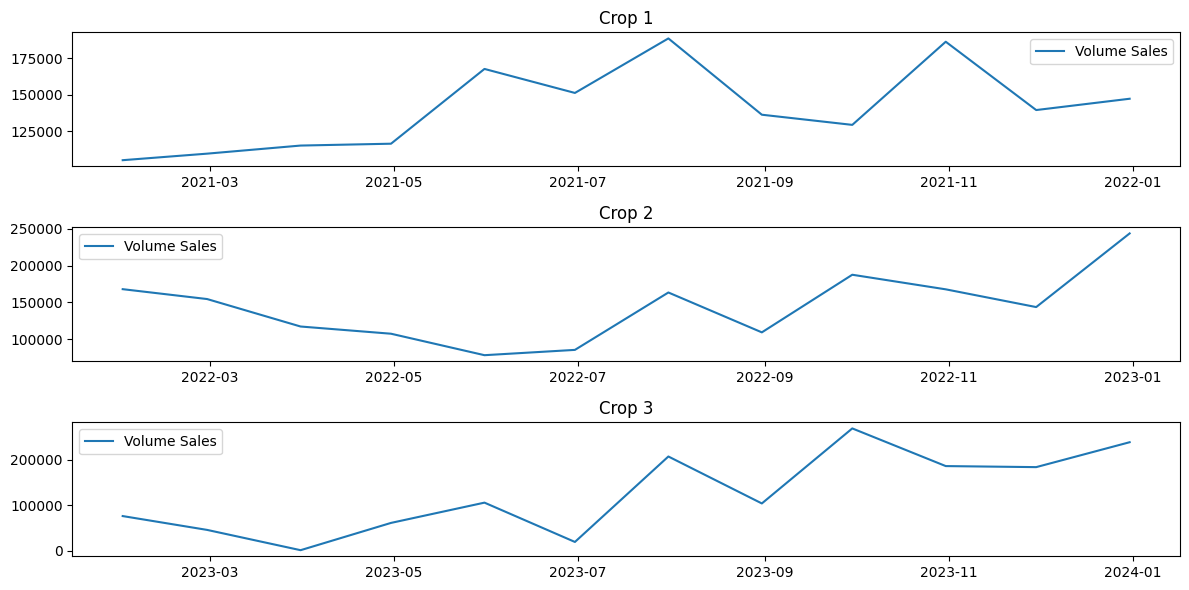

In [141]:
print("Data from {} to {}".format(filter_data["date"].min(), filter_data["date"].max()))
# print(filter_data.head())

# crop the data in 3 parts
size = int(len(filter_data) * 1 / 3)

crop1 = filter_data[:size]
crop2 = filter_data[size : 2 * size]
crop3 = filter_data[2 * size :]

print("Crop 1 from {} to {}".format(crop1["date"].min(), crop1["date"].max()))
print("Crop 2 from {} to {}".format(crop2["date"].min(), crop2["date"].max()))
print("Crop 3 from {} to {}".format(crop3["date"].min(), crop3["date"].max()))

# plot the 3 crops
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(crop1["date"], crop1["volume.sales"], label="Volume Sales")
plt.title("Crop 1")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(crop2["date"], crop2["volume.sales"], label="Volume Sales")
plt.title("Crop 2")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(crop3["date"], crop3["volume.sales"], label="Volume Sales")
plt.title("Crop 3")
plt.legend()

plt.tight_layout()
plt.show()

The data seems to have an annual seasonality, which looks good. 

Later, we should use this info to select the optimum value of the parameter d.

#### We'll see seasonal decomposition, ACF, and PACF plots.

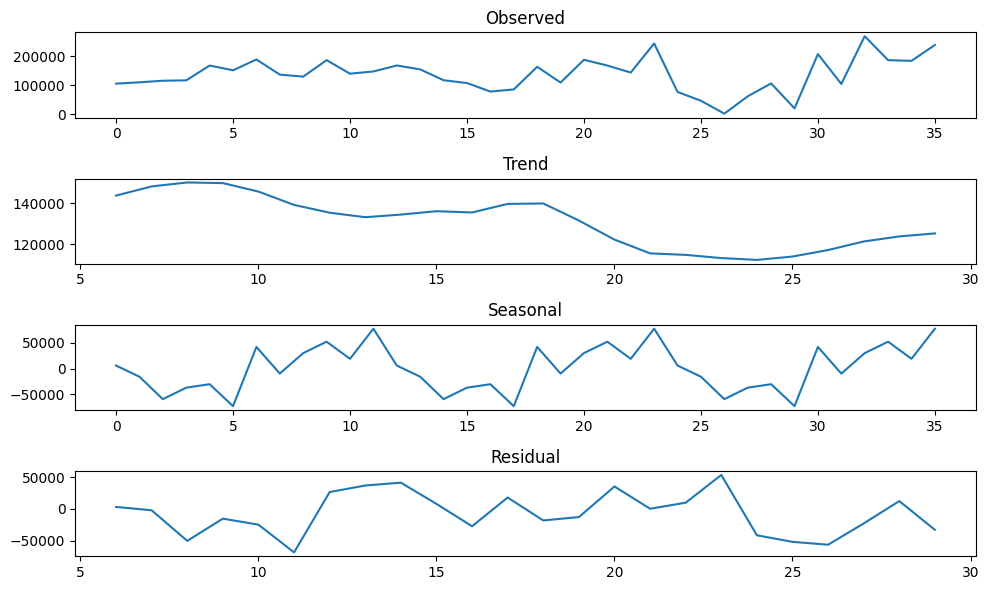

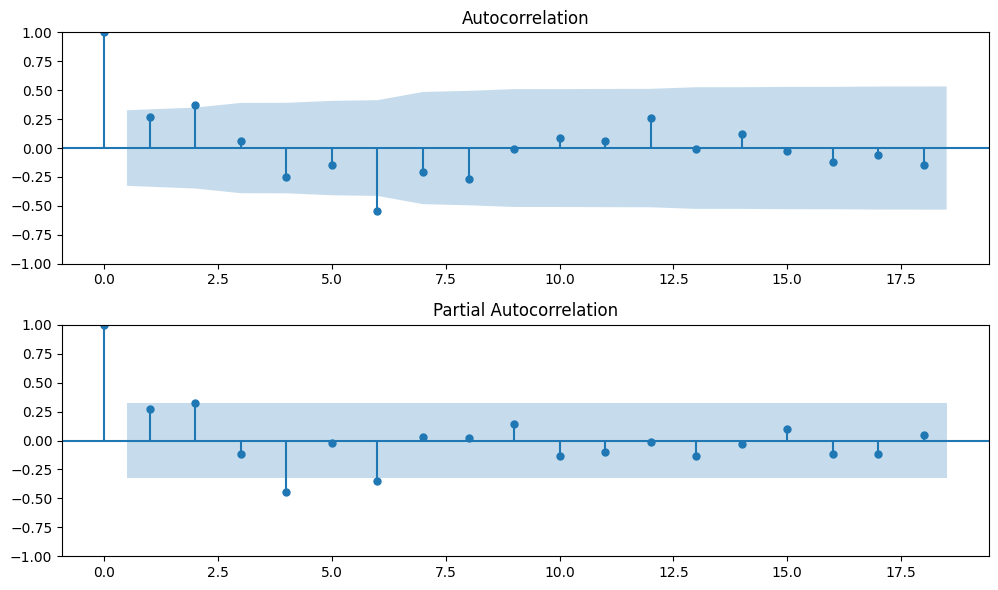

In [142]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
result = seasonal_decompose(filter_data["volume.sales"], model="additive", period=12)

# Create a custom larger figure for the decomposition
fig, axes = plt.subplots(4, 1, figsize=(10, 6))
axes[0].plot(result.observed)
axes[0].set_title("Observed")
axes[1].plot(result.trend)
axes[1].set_title("Trend")
axes[2].plot(result.seasonal)
axes[2].set_title("Seasonal")
axes[3].plot(result.resid)
axes[3].set_title("Residual")
plt.tight_layout()
plt.show()

# ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF in the same figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(filter_data["volume.sales"], lags=18, ax=axes[0])
plot_pacf(filter_data["volume.sales"], lags=18, ax=axes[1])
plt.tight_layout()
plt.show()

##### Now, we're gonna check it with ADF test and KPSS test

In [143]:
# Set date as index
filter_data.set_index("date", inplace=True)

Test stationarity series original
-------------------------------------
ADF Statistic: -4.065039528699305, p-value: 0.001105735298362
KPSS Statistic: 0.07964268328146942, p-value: 0.1

Test stationarity series differenced
-------------------------------------
ADF Statistic: -3.2185681232240326, p-value: 0.018934729302928412
KPSS Statistic: 0.08510787636980381, p-value: 0.1

Test stationarity series second differenced
-------------------------------------
ADF Statistic: -2.2842944883516525, p-value: 0.17708335274861559
KPSS Statistic: 0.091038414738134, p-value: 0.1
----------------------------------------------------------------------------------------------------


<Axes: title={'center': 'Diferenciación orden 2'}, xlabel='date'>

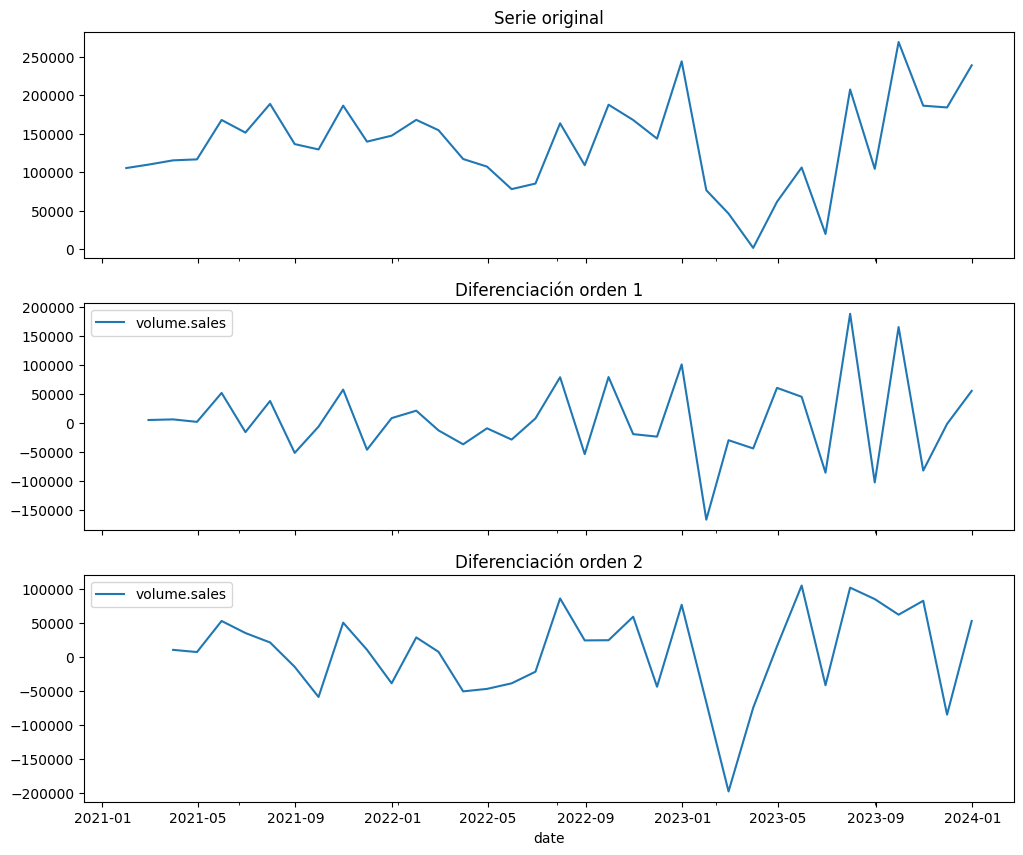

In [144]:
from statsmodels.tsa.stattools import kpss

print("=" * 100)

# Only apply diff() to numeric columns
filter_data_diff = filter_data[["volume.sales"]].diff().dropna()
filter_data_diff2 = filter_data[["volume.sales"]].diff(periods=2).dropna()

print("Test stationarity series original")
print("-------------------------------------")

adfuller_result = adfuller(filter_data["volume.sales"])
kpss_result = kpss(filter_data["volume.sales"])
print(f"ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}")
print(f"KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}")

print("\nTest stationarity series differenced")
print("-------------------------------------")

adfuller_result_diff = adfuller(filter_data_diff["volume.sales"])
kpss_result_diff = kpss(filter_data_diff["volume.sales"])
print(f"ADF Statistic: {adfuller_result_diff[0]}, p-value: {adfuller_result_diff[1]}")
print(f"KPSS Statistic: {kpss_result_diff[0]}, p-value: {kpss_result_diff[1]}")

print("\nTest stationarity series second differenced")
print("-------------------------------------")

adfuller_result_diff2 = adfuller(filter_data_diff2["volume.sales"])
kpss_result_diff2 = kpss(filter_data_diff2["volume.sales"])
print(f"ADF Statistic: {adfuller_result_diff2[0]}, p-value: {adfuller_result_diff2[1]}")
print(f"KPSS Statistic: {kpss_result_diff2[0]}, p-value: {kpss_result_diff2[1]}")

print("-" * 100)
# Gráfico series
# ==============================================================================
warnings.filterwarnings("ignore")

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), sharex=True)
filter_data["volume.sales"].plot(ax=axs[0], title="Serie original")
filter_data_diff.plot(ax=axs[1], title="Diferenciación orden 1")
filter_data_diff2.plot(ax=axs[2], title="Diferenciación orden 2")

We see how the ADF test shows a p-value of 0.001, indicating that we can reject the null hypothesis of non-stationarity. So, we can conclude that the time series is stationary.

ADF test: 
- Null hypothesis (H0): it is not stationary.
- Alternative scenario (H1): the series is stationary.
  
The KPSS test shows a statistic of 0.07, which is below the critical value of 0.739 at the 5% significance level. This indicates that we fail to reject the null hypothesis of stationarity. Therefore, we can conclude that the time series is stationary according to the KPSS test as well.

In original data, the p-value of KPSS is 0.1 above the 5% significance level, indicating that we accept the null hypothesis and *is not necessary to difference the series*. Ans it's stationary.

KPSS test: 
- Null hypothesis (H0): the series is stationary
- Alternative scenario (H1): the series is not stationary

**Conclusion: we'll use the parameter d=0 and D=1, cause the series is stationary in the original data and requires seasonal differencing. As we saw in the seasonal decomposition, there is a clear seasonal pattern that needs to be accounted for ARIMA and ARIMAX models.**

### Continuing with ARIMA and ARIMAX models (endogenous), with their respective predictions

statsmodels library

In [145]:

# Model SARIMAX with statsmodels.Sarimax
# ==============================================================================
train_data, test_data = sa.divide_data_for_train_and_test(filter_data)


from statsmodels.tsa.statespace.sarimax import SARIMAX

#TODO: show to Joaquin the code with autoarima
auto_model = sa.autoarima(train_data["volume.sales"])

model = SARIMAX(
    endog=train_data["volume.sales"], order=auto_model.order, seasonal_order=auto_model.seasonal_order
)
model_res = model.fit(disp=0)
warnings.filterwarnings("default")
model_res.summary()

# Forecasting
forecast_statsmodel = model_res.get_forecast(steps=len(test_data)).predicted_mean
forecast_statsmodel.name = "forecast_statsmodel"
display(forecast_statsmodel.head(4))

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=402.549, Time=0.17 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=401.775, Time=0.73 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=401.775, Time=0.73 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=402.615, Time=0.49 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=405.271, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=402.615, Time=0.49 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=405.271, Time=0.10 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=400.469, Time=0.19 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=400.469, Time=0.19 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=401.812, Time=0.40 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=401.812, Time=0.40 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=403.729, Time=0.78 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=402.652, Time=0.16 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=403.729, Time=0.78 sec
 ARIMA(2,0,0)(0,1,0)[12] intercep

2023-05-31     58401.302917
2023-06-30     76820.472420
2023-07-31    159853.511913
2023-08-31    107555.015000
Freq: ME, Name: forecast_statsmodel, dtype: float64

Skforecast library

In [146]:
from skforecast.sarimax import Sarimax

warnings.filterwarnings("ignore")

auto_model = sa.autoarima(train_data["volume.sales"])
model = Sarimax(order=auto_model.order, seasonal_order=auto_model.seasonal_order)
model.fit(y=train_data["volume.sales"])
model.summary()

forecast_skforecast = model.predict(steps=len(test_data))
display(forecast_skforecast.head(4))

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=402.549, Time=0.11 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=401.775, Time=0.36 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=401.775, Time=0.36 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=402.615, Time=0.32 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=405.271, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=400.469, Time=0.09 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=402.615, Time=0.32 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=405.271, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=400.469, Time=0.09 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=401.812, Time=0.23 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=401.812, Time=0.23 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=403.729, Time=0.52 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=402.652, Time=0.09 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=403.729, Time=0.52 sec
 ARIMA(2,0,0)(0,1,0)[12] intercep

,pred
2023-05-31,58401.302917
2023-06-30,76820.472420
2023-07-31,159853.511913
2023-08-31,107555.015000


pdmarima library

In [147]:
# Modelo SARIMAX con pdmarima.Sarimax
# ==============================================================================
from pmdarima import ARIMA

auto_model = sa.autoarima(train_data["volume.sales"])
model = ARIMA(order=auto_model.order, seasonal_order=auto_model.seasonal_order)
model.fit(y=train_data["volume.sales"])
model.summary()

# Prediction
# ==============================================================================
warnings.filterwarnings("ignore")
forecasting_pdmarima = model.predict(len(test_data))
forecasting_pdmarima.name = "predicciones_pdmarima"
display(forecasting_pdmarima.head(4))

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=402.549, Time=0.05 sec


 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=401.775, Time=0.34 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=402.615, Time=0.38 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=405.271, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=400.469, Time=0.06 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=402.615, Time=0.38 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=405.271, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=400.469, Time=0.06 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=401.812, Time=0.21 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=401.812, Time=0.21 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=403.729, Time=0.52 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=402.652, Time=0.11 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=403.729, Time=0.52 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=402.652, Time=0.11 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=403.052, Time=0.21 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=401.256, Time=0.20 sec
 ARIMA(1,0

2023-05-31     40170.784372
2023-06-30     50539.588586
2023-07-31    130028.201424
2023-08-31     76173.216933
Freq: ME, Name: predicciones_pdmarima, dtype: float64

Plot every forecasting in same figure

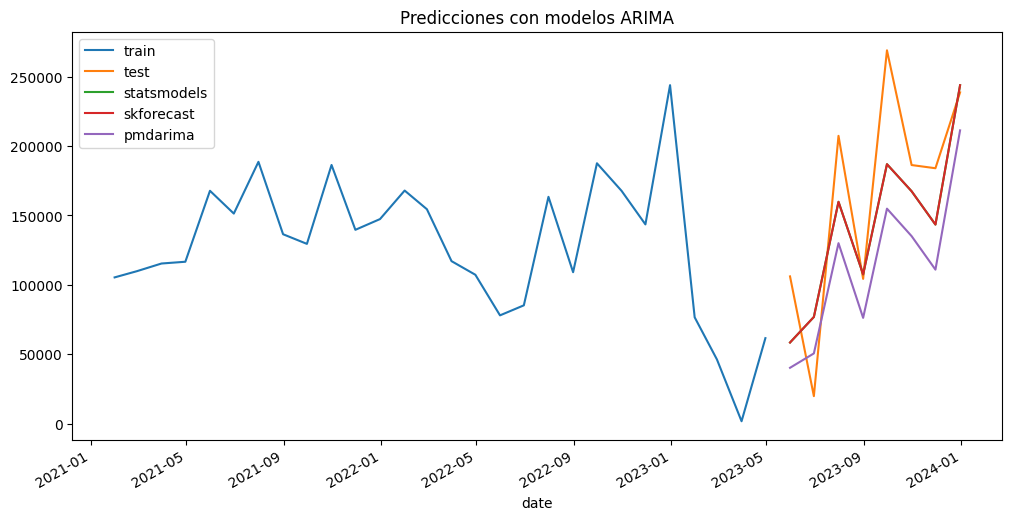

In [148]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 6))
train_data["volume.sales"].plot(ax=ax, label="train")
test_data["volume.sales"].plot(ax=ax, label="test")
forecast_statsmodel.plot(ax=ax, label="statsmodels")
forecast_skforecast.columns = ["skforecast"]
forecast_skforecast.plot(ax=ax, label="skforecast")
forecasting_pdmarima.plot(ax=ax, label="pmdarima")
ax.set_title("Predicciones con modelos ARIMA")
ax.legend()

### Continuation with models, but taking into account exogenous variables

{'order': (1, 0, 3),
 'aic': 111.33414301764371,
 'res': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2380e8bc3d0>}

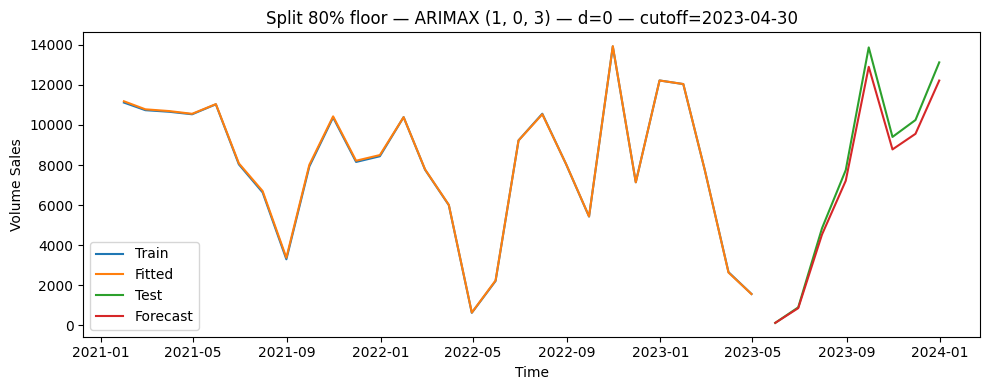

Test vs Forecast:
         Test      Forecast
28    126.756    126.250410
29    901.242    862.630771
30   4845.492   4533.324694
31   7749.126   7217.513190
32  13868.820  12900.183009
33   9403.488   8780.528899
34  10246.752   9557.746842
35  13122.288  12215.798144
MAE: 508.75
RMSE: 612.82
MAPE: 5.65%


In [149]:
import math

def adf_detailed(s):
    s = s.dropna().astype(float)
    stat, pval, *_ = adfuller(s, autolag="AIC")
    d = 0 if pval < 0.05 else 1
    return d, float(stat), float(pval), int(len(s))

#TODO: present both segments to Joaquin
data_filtered = data[
    (data["supermarket"] == "supermarket-A")
    & (data["variant"] == "flavoured")
    & (data["pack.size"] == "0 - 350 GR")
]
# data_filtered = data[
#     (data["supermarket"] == "supermarket-A")
#     & (data["variant"] == "standard")
#     & (data["pack.size"] == "351 - 500 GR")
# ]

data_filtered = data_filtered.dropna(subset=["date"]).sort_values(by="date").reset_index(drop=True) 

train_data, test_data = sa.divide_data_for_train_and_test(data_filtered)

d, adf_stat, adf_pval, n_train = adf_detailed(train_data["volume.sales"])

#Exogenous variables (only numeric)
exogs_cols = ["unit.sales", "value.sales", "price"]

y_train = train_data["volume.sales"]
X_train = train_data[exogs_cols]
y_test = test_data["volume.sales"]
X_test = test_data[exogs_cols]

# #order (p,d,q) and seasonal order (P,D,Q,s)
# def best_order(y, X, d, max_p=2, max_q=2):
#     best = None
#     for p in range(max_p+1):
#         for q in range(max_q+1):
#             if (p, d, q) == (0, 0, 0):
#                 continue
#             try:
#                 res = SARIMAX(y, exog=X, order=(p, d, q),
#                               enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
#                 if best is None or res.aic < best["aic"]:
#                     best = {"order": (p, d, q), "aic": res.aic, "res": res}
#             except Exception:
#                 continue
#     return best

def search_best_arima(endog, exog=None, d=0, max_p=3, max_q=3, seasonal_order=(0,1,0,12)):
    """Simple AIC grid search; returns dict with order,res or None if all fail."""
    best = None
    for p in range(max_p+1):
        for q in range(max_q+1):
            if (p,d,q) == (0,0,0):
                continue
            try:
                res = SARIMAX(endog, exog=exog, order=(p,d,q), seasonal_order=seasonal_order,
                               enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                if (best is None) or (res.aic < best['aic']):
                    best = {'order': (p,d,q), 'aic': res.aic, 'res': res}
            except Exception as e:
                # Uncomment for deeper debugging: print(f"Grid fail p={p} q={q}: {e}")
                continue
    return best

#FIXME: this method is the same as auto_arima from pmdarima?
# best = best_order(y_train, X_train, d=d, max_p=3, max_q=3) 
best = search_best_arima(y_train, exog=X_train, d=0)
order, res = best["order"], best["res"]
display(best)

 # Fitted + Forecast
fitted_tr = res.predict(start=y_train.index[0], end=y_train.index[-1], exog=X_train)
fc = res.get_forecast(steps=len(y_test), exog=X_test)
fc_mean = pd.Series(fc.predicted_mean, index=y_test.index)

# Métricas
mae = mean_absolute_error(y_test, fc_mean)
rmse = math.sqrt(mean_squared_error(y_test, fc_mean))
mape = (np.abs((y_test - fc_mean) / np.maximum(1e-9, np.abs(y_test)))).mean() * 100.0

# Plot
plt.figure(figsize=(10, 4))
plt.plot(train_data["date"], y_train, label="Train")
plt.plot(train_data["date"], fitted_tr, label="Fitted")
plt.plot(test_data["date"], y_test, label="Test")
plt.plot(test_data["date"], fc_mean, label="Forecast")
cutoff = train_data["date"].iloc[-1]
plt.title(f"Split 80% floor — ARIMAX {order} — d={d} — cutoff={cutoff}")
plt.xlabel("Time")
plt.ylabel("Volume Sales")
plt.legend()
plt.tight_layout()
plt.show()

#print values between test and forecast
print("Test vs Forecast:")
comparison = pd.DataFrame({
    "Test": y_test,
    "Forecast": fc_mean
})
print(comparison)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


Comparing models 

Segment rows: 36
Candidate exogenous columns: ['unit.sales', 'value.sales', 'price']
ADF p-value=0.010775373347559819 -> using d=0

Comparison table (lower is better):
                model      order           MAE          RMSE     MAPE_%
3   skforecast_ARIMAX  (2, 0, 3)      1.338269      1.607840   0.002534
1  statsmodels_ARIMAX  (3, 0, 0)      1.444393      1.771993   0.002540
0   statsmodels_ARIMA  (2, 0, 3)  34158.831688  40935.107116  42.580461
2    skforecast_ARIMA  (2, 0, 3)  38523.155454  48805.794844  45.580938

Comparison table (lower is better):
                model      order           MAE          RMSE     MAPE_%
3   skforecast_ARIMAX  (2, 0, 3)      1.338269      1.607840   0.002534
1  statsmodels_ARIMAX  (3, 0, 0)      1.444393      1.771993   0.002540
0   statsmodels_ARIMA  (2, 0, 3)  34158.831688  40935.107116  42.580461
2    skforecast_ARIMA  (2, 0, 3)  38523.155454  48805.794844  45.580938


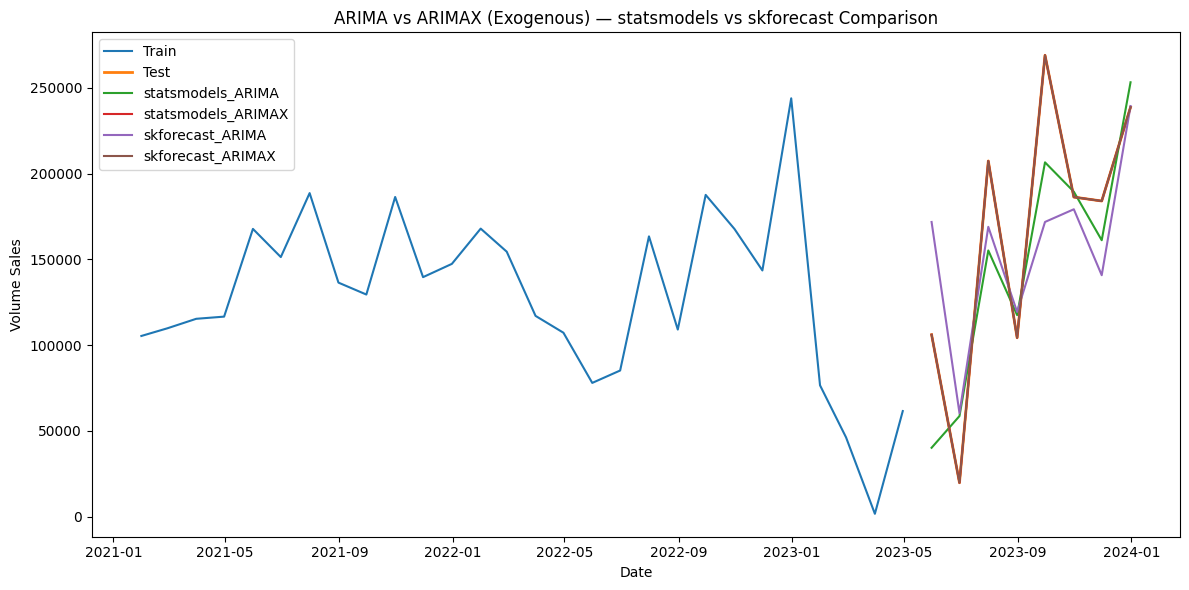


Best model: skforecast_ARIMAX
                Real       Forecast
date                               
2023-05-31  106070.5  106071.649337
2023-06-30   19729.5   19732.705552
2023-07-31  207420.5  207419.821748
2023-08-31  104294.5  104294.755892
2023-09-30  269082.5  269080.493800


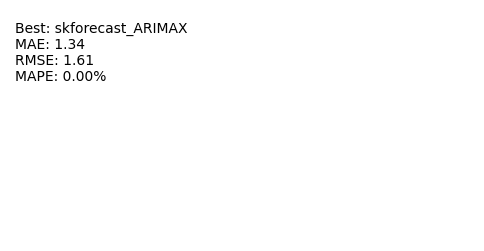

In [150]:
#TODO: ask Joaquin about the ARIMA model issues
#FIXME: check why the arima models are not working properly with different series


# ARIMA vs ARIMAX (with exogenous) comparison across libraries (statsmodels, skforecast)
# Hardened version with robust error handling and unified forecast extraction.
# If any model fails it will be skipped (reported) instead of stopping execution.

import warnings, math
from statsmodels.tsa.statespace.sarimax import SARIMAX
from skforecast.sarimax import Sarimax as SKF_Sarimax
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings('ignore')

# 1. Define a filtered dataset (same segmentation used earlier for consistency) -----------------

#TODO: present results with different segments to Joaquin
# segment = {
#     'supermarket': 'supermarket-A',
#     'variant': 'flavoured',
#     'pack.size': '0 - 350 GR'
# }
segment = {
    'supermarket': 'supermarket-A',
    'variant': 'standard',
    'pack.size': '351 - 500 GR'
}
# segment = {
#     'supermarket': 'supermarket-C',
#     'variant': 'standard',
#     'pack.size': '701 - 1000 GR'
# }

data_comp = (
    data[
        (data['supermarket'] == segment['supermarket']) &
        (data['variant'] == segment['variant']) &
        (data['pack.size'] == segment['pack.size'])
    ]
    .dropna(subset=['date'])
    .sort_values('date')
    .reset_index(drop=True)
)

print(f"Segment rows: {len(data_comp)}")
if len(data_comp) < 30:
    print('Warning: very short series for robust comparison; results may be unreliable.')

# 2. Train/test split -------------------------------------------------------------------------
try:
    train_data_comp, test_data_comp = sa.divide_data_for_train_and_test(data_comp)
except Exception as e:
    raise RuntimeError(f"divide_data_for_train_and_test failed: {e}")

# 3. Target & candidate exogenous columns -----------------------------------------------------
possible_exogs = ['unit.sales', 'value.sales', 'price']
exogs_cols_comp = [c for c in possible_exogs if c in train_data_comp.columns]

# Ensure only numeric exogs and with variance
exogs_cols_comp = [c for c in exogs_cols_comp if pd.api.types.is_numeric_dtype(train_data_comp[c])]
exogs_cols_comp = [c for c in exogs_cols_comp if train_data_comp[c].notna().sum() > 3 and train_data_comp[c].nunique() > 1]
print(f"Candidate exogenous columns: {exogs_cols_comp if exogs_cols_comp else 'None'}")

y_train_comp = train_data_comp['volume.sales']
y_test_comp  = test_data_comp['volume.sales']
X_train_comp = train_data_comp[exogs_cols_comp] if exogs_cols_comp else None
X_test_comp  = test_data_comp[exogs_cols_comp] if exogs_cols_comp else None

# 4. Helper utilities -------------------------------------------------------------------------

def safe_adfuller(series):
    s = series.dropna()
    if len(s) < 10:
        return 0, np.nan
    stat, pval, *_ = adfuller(s, autolag='AIC')
    return (0 if pval < 0.05 else 1), pval

def search_best_arima(endog, exog=None, d=0, max_p=3, max_q=3, seasonal_order=(0,1,0,12)):
    """Simple AIC grid search; returns dict with order,res or None if all fail."""
    best = None
    for p in range(max_p+1):
        for q in range(max_q+1):
            if (p,d,q) == (0,0,0):
                continue
            try:
                res = SARIMAX(endog, exog=exog, order=(p,d,q), seasonal_order=seasonal_order,
                               enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                if (best is None) or (res.aic < best['aic']):
                    best = {'order': (p,d,q), 'aic': res.aic, 'res': res}
            except Exception as e:
                # Uncomment for deeper debugging: print(f"Grid fail p={p} q={q}: {e}")
                continue
    return best

def extract_series(pred):
    """Return forecast as Series regardless of underlying object (Series/DataFrame)."""
    if isinstance(pred, pd.Series):
        return pred
    if isinstance(pred, pd.DataFrame):
        if 'pred' in pred.columns:
            return pred['pred']
        return pred.iloc[:,0]
    return pd.Series(pred)

# Determine d ---------------------------------------------------------------------------------
d_local, adf_p_local = safe_adfuller(y_train_comp)
print(f"ADF p-value={adf_p_local if not np.isnan(adf_p_local) else 'NA'} -> using d={d_local}")

models_results = {}
skipped = []

# 5. Fit models --------------------------------------------------------------------------------
# statsmodels ARIMA (no exogenous)
try:
    best_arima = search_best_arima(y_train_comp, exog=None, d=d_local)
    if best_arima is None:
        raise ValueError('No ARIMA configuration converged.')
    arima_res = best_arima['res']
    y_forecast_arima = arima_res.get_forecast(steps=len(y_test_comp)).predicted_mean
    models_results['statsmodels_ARIMA'] = {
        'order': best_arima['order'],
        'forecast': y_forecast_arima
    }
except Exception as e:
    skipped.append(f'statsmodels_ARIMA: {e}')

# statsmodels ARIMAX (with exogenous)
if X_train_comp is not None and len(exogs_cols_comp)>0:
    try:
        best_arimax = search_best_arima(y_train_comp, exog=X_train_comp, d=d_local)
        if best_arimax is None:
            raise ValueError('No ARIMAX configuration converged.')
        arimax_res = best_arimax['res']
        y_forecast_arimax = arimax_res.get_forecast(steps=len(y_test_comp), exog=X_test_comp).predicted_mean
        models_results['statsmodels_ARIMAX'] = {
            'order': best_arimax['order'],
            'forecast': y_forecast_arimax
        }
    except Exception as e:
        skipped.append(f'statsmodels_ARIMAX: {e}')
else:
    skipped.append('statsmodels_ARIMAX: no exogenous columns')

# skforecast SARIMAX (no exogenous)
try:
    if 'statsmodels_ARIMA' in models_results:
        skf_arima = SKF_Sarimax(order=models_results['statsmodels_ARIMA']['order'], seasonal_order=(0,1,0,12))
    else:
        skf_arima = SKF_Sarimax(order=(1,d_local,0), seasonal_order=(0,1,0,12))
    skf_arima.fit(y=y_train_comp)
    skf_arima_forecast = extract_series(skf_arima.predict(steps=len(y_test_comp)))
    models_results['skforecast_ARIMA'] = {
        'order': skf_arima.order,
        'forecast': pd.Series(skf_arima_forecast.values, index=y_test_comp.index)
    }
except Exception as e:
    skipped.append(f'skforecast_ARIMA: {e}')

# skforecast SARIMAX (with exogenous)
if X_train_comp is not None and len(exogs_cols_comp)>0:
    try:
        base_order = models_results.get('statsmodels_ARIMA', {}).get('order', (1,d_local,0))
        skf_arimax = SKF_Sarimax(order=base_order, seasonal_order=(0,1,0,12))
        skf_arimax.fit(y=y_train_comp, exog=X_train_comp)
        skf_arimax_forecast = extract_series(skf_arimax.predict(steps=len(y_test_comp), exog=X_test_comp))
        models_results['skforecast_ARIMAX'] = {
            'order': base_order,
            'forecast': pd.Series(skf_arimax_forecast.values, index=y_test_comp.index)
        }
    except Exception as e:
        skipped.append(f'skforecast_ARIMAX: {e}')
else:
    skipped.append('skforecast_ARIMAX: no exogenous columns')

# 6. Metrics -----------------------------------------------------------------------------------
rows = []
for model_name, props in models_results.items():
    try:
        f = props['forecast']
        common_index = y_test_comp.index.intersection(f.index)
        if len(common_index) == 0:
            raise ValueError('No overlapping index with test set')
        y_true_aligned = y_test_comp.loc[common_index]
        f_aligned = f.loc[common_index]
        mae = mean_absolute_error(y_true_aligned, f_aligned)
        rmse = math.sqrt(mean_squared_error(y_true_aligned, f_aligned))
        mape = (np.abs((y_true_aligned - f_aligned) / np.maximum(1e-9, np.abs(y_true_aligned)))).mean() * 100
        rows.append({
            'model': model_name,
            'order': props['order'],
            'MAE': mae,
            'RMSE': rmse,
            'MAPE_%': mape
        })
    except Exception as e:
        skipped.append(f'metrics {model_name}: {e}')

if rows:
    comparison_table = pd.DataFrame(rows).sort_values('MAPE_%')
    print('\nComparison table (lower is better):')
    print(comparison_table)
else:
    comparison_table = pd.DataFrame()
    print('No successful model forecasts to compare.')

if skipped:
    print('\nSkipped / errors:')
    for msg in skipped:
        print(' -', msg)

# 7. Plot forecasts ---------------------------------------------------------------------------
if rows:
    plt.figure(figsize=(12,6))
    plt.plot(train_data_comp['date'], y_train_comp, label='Train')
    plt.plot(test_data_comp['date'], y_test_comp, label='Test', linewidth=2)
    for model_name, props in models_results.items():
        plt.plot(test_data_comp['date'], props['forecast'], label=model_name)
    plt.title('ARIMA vs ARIMAX (Exogenous) — statsmodels vs skforecast Comparison')
    plt.xlabel('Date')
    plt.ylabel('Volume Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 8. Detailed side-by-side real vs best forecast ----------------------------------------------
if not comparison_table.empty:
    best_model = comparison_table.iloc[0]['model']
    best_forecast = models_results[best_model]['forecast']
    comparison_detailed = pd.DataFrame({
        'Real': y_test_comp.values,
        'Forecast': best_forecast.values
    }, index=test_data_comp['date'])
    print(f"\nBest model: {best_model}")
    print(comparison_detailed.head())

    # Text box summary (optional)
    textstr = '\n'.join([
        f"Best: {best_model}",
        f"MAE: {comparison_table.iloc[0]['MAE']:.2f}",
        f"RMSE: {comparison_table.iloc[0]['RMSE']:.2f}",
        f"MAPE: {comparison_table.iloc[0]['MAPE_%']:.2f}%"
    ])
    fig, ax = plt.subplots(figsize=(6,3))
    ax.axis('off')
    ax.text(0.01,0.95,textstr, va='top')
    plt.show()
else:
    print('No best model summary due to all failures.')